## Problem 3

In [0]:
from os.path import exists
from google.colab import drive
import os
drive.mount('/content/dirve/', force_remount = True)
# change to your own directory
os.chdir("dirve/My Drive/Colab Notebooks/IFT6135/hw3/")
#!ls -al
from IPython.display import Image

In [2]:
import numpy as np
import torch.nn as nn
import torch
import random
import math
import scipy.io as sio
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import save_image

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
print(cuda)

# build two directories for saving model and submission files.
data_dir = "./data/"
model_dir = "./model/"
image_dir = "./image/"
image_dir_gan = "./image/gan/"
image_dir_vae = "./image/vae/"

folders = [data_dir, model_dir, image_dir, image_dir_gan, image_dir_vae]
for i in range(len(folders)):
    os.makedirs(folders[i], exist_ok = True)

True


In [0]:
# load original data
train_valid_dict = sio.loadmat(data_dir + "train_32x32.mat")
test_dict = sio.loadmat(data_dir + "test_32x32.mat")

In [70]:
# data preprocessing: type convert, train_valid split, etc.

train_valid_X, train_valid_y = train_valid_dict["X"], train_valid_dict["y"]
test_X, test_y = test_dict["X"], test_dict["y"]

train_valid_X_T = Tensor(train_valid_X).permute(3,2,0,1) / 255.0  # to [0, 1]
train_valid_y_T = Tensor(train_valid_y)

test_X_T = Tensor(test_X).permute(3,2,0,1) / 255.0 # to [0, 1]
test_y_T = Tensor(test_y)

n_train_valid = train_valid_X_T.size(0)
n_test = test_X_T.size(0)
n_train = 60000 # set size of train_set be 6000
n_channels, n_img_size = 3, 32

print(n_train_valid, n_train, n_test)
print(train_valid_X_T.size(), train_valid_y_T.size())


#print(train_valid_X_T.view(n_train_valid, -1).shape)

train_valid_set = torch.cat((train_valid_X_T.contiguous().view(n_train_valid, -1), 
                             train_valid_y_T) , dim = 1)
train_set = train_valid_set[:n_train,:]
valid_set = train_valid_set[n_train:,:]

test_set = torch.cat((test_X_T.contiguous().view(n_test, -1), test_y_T), dim = 1)

print(train_set.shape, valid_set.shape, test_set.shape)

def data_loader(data, batch_size = 64):
    """returned data has a shape [batch_size, 3*32*32+1]"""
    return DataLoader(data, batch_size = batch_size, shuffle = True)


def split_to_X_y(batch_data):
    """
    """
    X = batch_data[:,:-1].view(batch_data.size(0), 3, 32, 32)
    y = batch_data[:,-1]
    return X, y

73257 60000 26032
torch.Size([73257, 3, 32, 32]) torch.Size([73257, 1])
torch.Size([60000, 3073]) torch.Size([13257, 3073]) torch.Size([26032, 3073])


torch.Size([64, 3073])


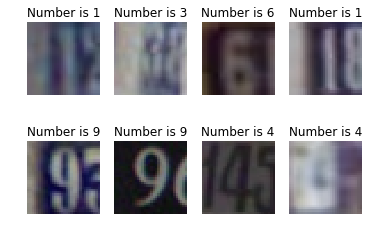

In [71]:
# visualize some images

train_loader = data_loader(train_set)
for i, train_batch in enumerate(train_loader):
    print(train_batch.shape)
    X, y = split_to_X_y(train_batch)
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.title('Number is '+np.str(np.int(y[i].item())))
        plt.imshow(X[i].cpu().permute(1,2,0))# / 255.0)
        plt.axis('off')
    break
    
# all values in an example are between 0 and 255    
#print(X[0])    

In [0]:
class Encoder(nn.Module):
    def __init__(self, z_dim = 100):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        self.encode = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = (3,3)),      # 32 -> 30
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size = (3,3)),     # 30 -> 28
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size = (3,3)),     # 28 -> 26
            nn.ELU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),  # 26 -> 13
            nn.Conv2d(64, 128, kernel_size = (3,3)),    # 13 -> 11
            nn.ELU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),  # 11 -> 5
            nn.Conv2d(128, 256, kernel_size = (5,5)),   # 5  -> 1
            nn.ELU(),
        )
        self.linear1 = nn.Linear(in_features = 256, out_features = 2*z_dim)
        
        
    def forward(self, x):                          # [batch_size, 3, 32, 32]
        q = self.encode(x)                         # [batch_size, 256, 1, 1]
        q = self.linear1(q.view(q.size(0), -1))    # [batch_size, 200]
        mu, log_var = q[:,:z_dim], q[:, z_dim: ]   # [batch_size, 100] 
        return mu, log_var
    
    
class Generator(nn.Module):
    def __init__(self, z_dim = 100):
        """
        params
            z_dim: dimension of latent space
            sampling_generate: if use sampling to produce final image data, bool
                False for default
        """
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.linear2 = nn.Linear(in_features = z_dim, out_features = 256)
        self.decode = nn.Sequential(                       # 256, 1, 1
            nn.ELU(),
            nn.Conv2d(256, 128, kernel_size=5, padding=4), # 128, 5, 5
            nn.ELU(),
            nn.UpsamplingBilinear2d(scale_factor=2),       # 128, 10, 10
            nn.Conv2d(128, 64, kernel_size=3, padding=2),  #  64, 12 ,12
            nn.ELU(),
            nn.UpsamplingBilinear2d(scale_factor=2),       #  64, 24, 24
            nn.Conv2d(64, 32, kernel_size=3, padding=2),   #  32, 26, 26
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=2),   #  32 28, 28
            nn.ELU(),
            nn.Conv2d(32, 16, kernel_size = 3, padding=2), #  16,0, 30
            nn.ELU(),
            nn.Conv2d(16, 3, kernel_size = 3, padding=2),  #   3, 32, 32
        )
        
    def forward(self, z):
        x_ = self.linear2(z).view(z.size(0),-1, 1,1) # [batch_size, 256, 1, 1]
        #print(x_.shape)
        x_ = self.decode(x_)                       #[batch_size, 1, 28, 28] 
        return x_
    
        

class Discriminator(nn.Module):
    def __init__(self, input_dim = 3*32*32):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            # need a sigmoid to force output be 0 to 1??
        )

    def forward(self, x):    # [batch_size, 3, 32, 32]
        validity = self.model(x.view(x.size(0), -1))
        return validity
    
    
# use CNN as a discriminator, will try this later if the first doesn't work       
class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = (3,3)),      # 32 -> 30
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size = (3,3)),     # 30 -> 28
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size = (3,3)),     # 28 -> 26
            nn.ELU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2), # 26 -> 13
            nn.Conv2d(64, 128, kernel_size = (3,3)),    # 13 -> 11
            nn.ELU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2), # 11 -> 5
            nn.Conv2d(128, 256, kernel_size = (5,5)),   # 5  -> 1
            nn.ELU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(in_features = 256, out_features = 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features = 64, out_features = 1)
        )
        
        
    def forward(self, x):                         # [batch_size, 3, 32, 32]
        q = self.encode(x)                        # [batch_size, 256, 1, 1]
        validity = self.fc(q.view(q.size(0), -1))        # [batch_size, 1]
        return validity
    
    
def sampling(mu, log_var = None):
    """this method can be used in two situations: 
    1) generate latent variables by output of an VAE encoder 
    2) generate reconstructed images by output of Generator in VAE  or WGAN
    """
    if log_var is None:
        std = Tensor(np.ones(tuple(mu.size())))
    else:
        std = torch.exp(0.5*log_var) 
    eps = torch.randn_like(std)
    return mu + torch.mul(eps, std)    
    
    
class VAE(nn.Module):
    def __init__(self, z_dim = 100):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = Encoder(z_dim = z_dim)
        self.generator = Generator(z_dim = z_dim)
        self.sampling = sampling
    
    def forward(self, x):                 #[batch_size, 3, 32, 32]
        mu, log_var = self.encoder(x)     #[batch_size, 100] both
        z = self.sampling(mu, log_var)    #[batch_size, 100]
        x_ = self.generator(z)            #[batch_size, 3, 32, 32]
        x_ = self.sampling(x_, None)      # work well here. :) remove also well.
        return x_, mu, log_var
    
    def kld(self, mu, log_var):
        for_sum = -1 - log_var + torch.pow(mu, 2) + torch.exp(log_var)
        kld = 0.5 * torch.sum(for_sum, dim = 1, keepdim = True)        
        return torch.mean(kld)
    
    def cross_entropy_loss(self, x_, x):
        #cross_entropy loss
        ce = F.binary_cross_entropy_with_logits(x_, x, reduction = "none")
        ce = torch.sum(ce.view(ce.size(0), -1), dim = 1, keepdim = True)
        ce = torch.mean(ce)  
        return ce
        
    def mse_loss(self, x_, x):
        # x_ is reconstructed x
        #
        mse = F.mse_loss(x_, x, reduction = "none")
        mse = torch.sum(mse.view(mse.size(0), -1), dim = 1, keepdim = True)
        mse = torch.mean(mse)  
        return mse        
        
    def loss(self, x_, x, mu, log_var):
        """
        params
            mu, log_var = encoder(x)
            recon_x: sampling(generator(sampling(mu, log_var)))
            x: original x
        returns
            MSE+KLD, MSE, KLD
        """
        mse, kld = self.cross_entropy_loss(x_, x), self.kld(mu, log_var)
        return mse + kld, mse, kld
    
    
class WGAN(nn.Module):
    def __init__(self, z_dim = z_dim):
        super(WGAN, self).__init__()
        self.generator = Generator(z_dim = z_dim)
        self.discriminator = Discriminator()

    def forward(self, z):   # z is sampled from N(0, I) [batch_size, z_dim]
        # we don't directly use this method. use
        #x = self.generator(z)
        pass
    
    def generate(self, z):
        x_ = self.generator(z)
        return x_
    
    def discriminate(self, x):
        validity = self.discriminator(x.view(x.size(0), 3, 32, 32))
        return validity
    
    def grad_penalty(self, real_samples, fake_samples):
        """Calculates the gradient penalty loss for WGAN GP"""
        # Random weight term for interpolation between real and fake samples
        
        #print("shape of real fake samples:", real_samples.shape, fake_samples.shape)
        D = self.discriminator
        batch_size = real_samples.size(0)
        alpha = np.random.random((batch_size, 1, 1, 1))
        alpha = Tensor(alpha)
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
        interpolates.requires_grad_(True)
        d_interpolates = D(interpolates)
        grad_outputs = Tensor(batch_size, 1).fill_(1.0)
        # Get gradient w.r.t. interpolates

        gradients = torch.autograd.grad(
            outputs = d_interpolates,
            inputs = interpolates,
            grad_outputs = grad_outputs,
            create_graph = True,
            retain_graph = True,
            only_inputs = True,
        )[0]
        gradients = gradients.view(batch_size, -1)
        #gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        gradient_penalty = ((gradients.norm(2, dim = 1) - 1) ** 2).mean()
        return gradient_penalty
    
    def wasserstein_distance(self, real_validity, fake_validity):
        return torch.mean(real_validity) - torch.mean(fake_validity)
    

In [101]:
# globals, vae and gan, train and valid data
batch_size = 64
z_dim = 100
max_epochs = 100
max_patience = 10 


train_loader = data_loader(train_set, batch_size = batch_size)
valid_loader = data_loader(valid_set, batch_size = batch_size)
train_set_size = len(train_loader)
print(train_set_size)

938


In [0]:
def train_vae(vae,
              train_loader,
              valid_loader,
              lr = 3e-4,
              max_epochs = 100,
              max_patiences = 100,
              best_model_path = "best_model.vae",
             ):
    
    optimizer = torch.optim.Adam(vae.parameters(), lr = lr)
    vae_best = vae.state_dict() # for best vae model
    best_val_loss = None
    patience_used = 0  # for early stop
    phases = ["train", "valid"]
    data_loaders = {"train": train_loader, "valid": valid_loader}
    
    for epoch in range(max_epochs):
        print("Epoch[{}/{}]".format(epoch+1, max_epochs), end = " ")
        for phase in phases:
            print(phase, end = " ")
            if phase == "train":
                vae.train()
            else:
                vae.eval()

            avg_loss, avg_mse, avg_kld, set_size = 0.0, 0.0, 0.0, 0
            for idx, data in enumerate(data_loaders[phase]):
                x, y = split_to_X_y(data)
                batch_size = x.size(0)
                x_, mu, log_var = vae(x)
                loss, mse, kld = vae.loss(x_, x, mu, log_var)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                avg_loss += loss.item() * batch_size
                avg_mse += mse.item() * batch_size
                avg_kld += kld.item() * batch_size
                set_size += batch_size

            avg_loss /= set_size
            avg_mse /= set_size
            avg_kld /= set_size

            print("loss:{:.2f} mse:{:.2f} kld:{:.2f}".format(
                avg_loss, avg_mse, avg_kld), end = "  ")

            # check early stop
            if phase == "valid":
                if best_val_loss is None or best_val_loss > avg_loss:
                    best_val_loss = avg_loss
                    vae_best = vae.state_dict()
                    torch.save(vae_best, best_model_path)
                    patience_used = 0
                    print("*")

                else:
                    patience_used += 1
                    print("")
                    
            if patience_used >= max_patience: # early stop
                vae.load_state_dict(vae_best)
                print("early stop")
                return # stop training  
                
        if epoch % 1 == 0: #generate some images 
            z = Tensor(np.random.normal(0, 1, (64, vae.z_dim)))
            fake_x = vae.generator(z)
            save_image(fake_x.data[:64], 
                       image_dir_vae + "vae_{}.png".format(epoch), 
                       nrow=8, normalize=True)
            
    # finish all epochs
    vae.load_state_dict(vae_best)     

In [0]:
vae = VAE(z_dim = z_dim)
if cuda:
    vae.cuda()
    
os.makedirs(image_dir_vae, exist_ok = True)   
save_path = model_dir + "best_model.vae"
#if exists(save_path):
#    vae.load_state_dict(torch.load(save_path))

train_vae(vae,
          train_loader,
          valid_loader,
          lr = 3e-4,
          max_epochs = 200,
          max_patiences = 200, # don't use early stop
          best_model_path = "best_model.vae",
         )

In [0]:
# train a WGAN
def train_wgan(gan,
               train_loader,
               valid_loader = None,
               lr = 1e-4,
               betas=(0.0, 0.9),
               max_epochs = 100,
               best_model_path = "best_model.gan",
               lambda_gp = 10,
               n_critic = 5,
              ):
    G, D = gan.generator, gan.discriminator    

    #optim_D = torch.optim.RMSprop(D.parameters(), lr=d_learning_rate)
    optim_D = torch.optim.Adam(D.parameters(), lr = lr, betas = betas)
    optim_G = torch.optim.Adam(G.parameters(), lr = lr, betas = betas)
    batches_done = 0

    for epoch in range(max_epochs):
        gan.train()
        avg_d_loss, avg_wd, avg_g_loss, d_size, g_size =0.0, 0.0, 0.0, 0, 0
        for idx, data in enumerate(train_loader):
            
            real_x, _ = split_to_X_y(data)
            batch_size = real_x.size(0)
            # train a discriminator
            optim_D.zero_grad()     
            #optim_G.zero_grad()
            
            z = Tensor(np.random.normal(0, 1, (batch_size, G.z_dim)))
            fake_x = G(z)
            #fake_x = sampling(fake_x, log_var = None) # doesn' work well
            
            real_validity = D(real_x)
            fake_validity = D(fake_x)
            
            gradient_penalty = gan.grad_penalty(real_x.data, fake_x.data)

            wd = torch.mean(real_validity) - torch.mean(fake_validity) 
            d_loss = -1 * wd + lambda_gp * gradient_penalty
            
            d_loss.backward()
            optim_D.step()
            
            d_size += batch_size
            avg_d_loss += d_loss.item() * batch_size
            avg_wd += wd.item() * batch_size
            batches_done += 1
            
            optim_G.zero_grad()
            # train a generator every n_critic steps
            if batches_done % n_critic == 0:
                #optim_D.zero_grad()  # clear gradient optim_D
                
                fake_x = G(z)
                #fake_x = sampling(fake_x, log_var = None) # doesn't work well
                fake_validity = D(fake_x)
                g_loss = -torch.mean(fake_validity)                    
                g_loss.backward()
                optim_G.step()
                
                g_size += batch_size
                avg_g_loss += g_loss.item() * batch_size

        
        avg_g_loss /= g_size
        avg_d_loss /= d_size
        avg_wd /= d_size
        
        if epoch % 1 == 0:
            z = Tensor(np.random.normal(0, 1, (64, G.z_dim)))
            fake_x = G(z)
            save_image(fake_x.data, 
                       image_dir_gan + "gan_{}.png".format(epoch), 
                       nrow=8, normalize=True)

        print("[Epoch {}/{}] [Batch {}/{}] D_loss: {:.2f} WD:{:.2f} G_loss: {:.2f}"
              .format(epoch, max_epochs, idx, len(train_loader),
                      avg_d_loss, avg_wd, avg_g_loss, n_critic))                    
                
        if epoch % 1 == 0:
            torch.save(gan.state_dict(), best_model_path)
    # finish all epochs

In [0]:
gan = WGAN(z_dim = z_dim)
if cuda:
    gan.cuda()
    
os.makedirs(image_dir_gan, exist_ok = True)    
save_path = model_dir + "best_model.gan"
if exists(save_path):
    gan.load_state_dict(torch.load(save_path))
    
train_wgan(gan, train_loader, max_epochs = 200, lr = 1e-4, betas=(0.0, 0.9),
           lambda_gp = 10, n_critic = 5, best_model_path = save_path)

In [0]:
#problem 3 Qualitative Evaluation 2 compare z and z_epsilon

def show_image_variation(generator, epsilon = 10, batch_size = 64, z_dim = 100):
    z = Tensor(np.random.normal(0, 1, (batch_size, z_dim)))
    for dim in range(z_dim): # each dimension        
        z_prime = z.clone()
        z_prime[:, dim] += epsilon

        zs = [z, z_prime]
        for i, zi in enumerate(zs):
            xi = generator(zi)
            label = "z" if i == 0 else "z_eps"
            save_image(xi.data,  base_dir + "{}_dim_{}.png".format(label, dim), 
                       nrow=8, normalize=True)

In [141]:
base_dir = "./image/problem3_2/"
os.makedirs(base_dir, exist_ok = True) 
show_image_variation(vae.generator, epsilon = 10)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
